<a href="https://colab.research.google.com/github/ArielFerreiro/ar-stamp-checker/blob/main/attempt.01/03_InceptionNet_NoAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the imaged croped and without augmentation. We create a model using CNN inception architecture pre-trained with imagenet and evaluate the accuracy results to get fake vs genuine stamps.

In [1]:
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Notebook Imports

In [3]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model,Sequential
from keras.layers.core import Dense, Flatten, Activation
from keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Dropout, MaxPooling2D, Input, Add
import numpy as np
import pickle
import os

#### Global Params


In [4]:
results_path = 'drive/My Drive/Colab Notebooks/stamps/results/'
models_path = 'drive/My Drive/Colab Notebooks/stamps/models/'
test_path = 'drive/My Drive/Colab Notebooks/stamps/test/'

#### Data Load

In [5]:
with open(results_path+"stamps_bb_299.pkl","rb") as f:
    (stamps_df, y) = pickle.load(f)

#### Model Creation

In [6]:
preproc=InceptionResNetV2(include_top = False, pooling = None, weights="imagenet",input_shape=(299, 299, 3))

In [7]:
# Fix the transfer layers not to be trained
for layer in preproc.layers:
    layer.trainable=False

In [8]:
# Dictionary of Layers
outputs_dict = dict([(layer.name, layer.output) for layer in preproc.layers])

In [9]:
net = BatchNormalization(axis=3)(outputs_dict['conv_7b_ac']) 
net=Flatten()(net)
net=Dense(units=512)(net)
net = Activation('relu')(net)
#net=Dropout(0.3)(net)
net=Dense(units=256)(net)
net = Activation('relu')(net)
#net=Dropout(0.3)(net)

# USES Softmax as it is a requirement for the TF Lite add-in used in the mobile app
net=Dense(units=2, activation = 'softmax', kernel_regularizer=keras.regularizers.L2(l2=0.02))(net)
 
model=Model(preproc.inputs,net)
#model.summary()

In [10]:
# Callbacks
checkpoint_file='checkpoint.pmi-cnn-Inception.hdf5'
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=2)
checkpointer = ModelCheckpoint(monitor="val_accuracy",filepath=checkpoint_file, verbose=1, save_best_only=True)

In [11]:
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', keras.metrics.AUC()])

In [12]:
epocs = 50
# Move the y-true to categorical
y_categorical = keras.utils.to_categorical(y) 

In [13]:
stamps_df = stamps_df / 255

In [14]:
history = model.fit(x= stamps_df, y=y_categorical,
                    epochs=epocs, verbose=1, 
                    validation_split=0.2,
                    callbacks=[checkpointer, earlystop])

Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 3.9588 - accuracy: 0.8510 - auc: 0.8746
Epoch 00001: val_accuracy improved from -inf to 0.71429, saving model to checkpoint.pmi-cnn-Inception.hdf5
48/48 [==============================] - 29s 602ms/step - loss: 3.9588 - accuracy: 0.8510 - auc: 0.8746 - val_loss: 3.7215 - val_accuracy: 0.7143 - val_auc: 0.7386
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.7591 - accuracy: 0.9497 - auc: 0.9639
Epoch 00002: val_accuracy improved from 0.71429 to 0.92063, saving model to checkpoint.pmi-cnn-Inception.hdf5
48/48 [==============================] - 25s 518ms/step - loss: 0.7591 - accuracy: 0.9497 - auc: 0.9639 - val_loss: 1.3135 - val_accuracy: 0.9206 - val_auc: 0.9526
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.2646 - accuracy: 0.9781 - auc: 0.9855
Epoch 00003: val_accuracy did not improve from 0.92063
48/48 [==============================] - 20s 423ms/step - loss: 0.2646 - acc

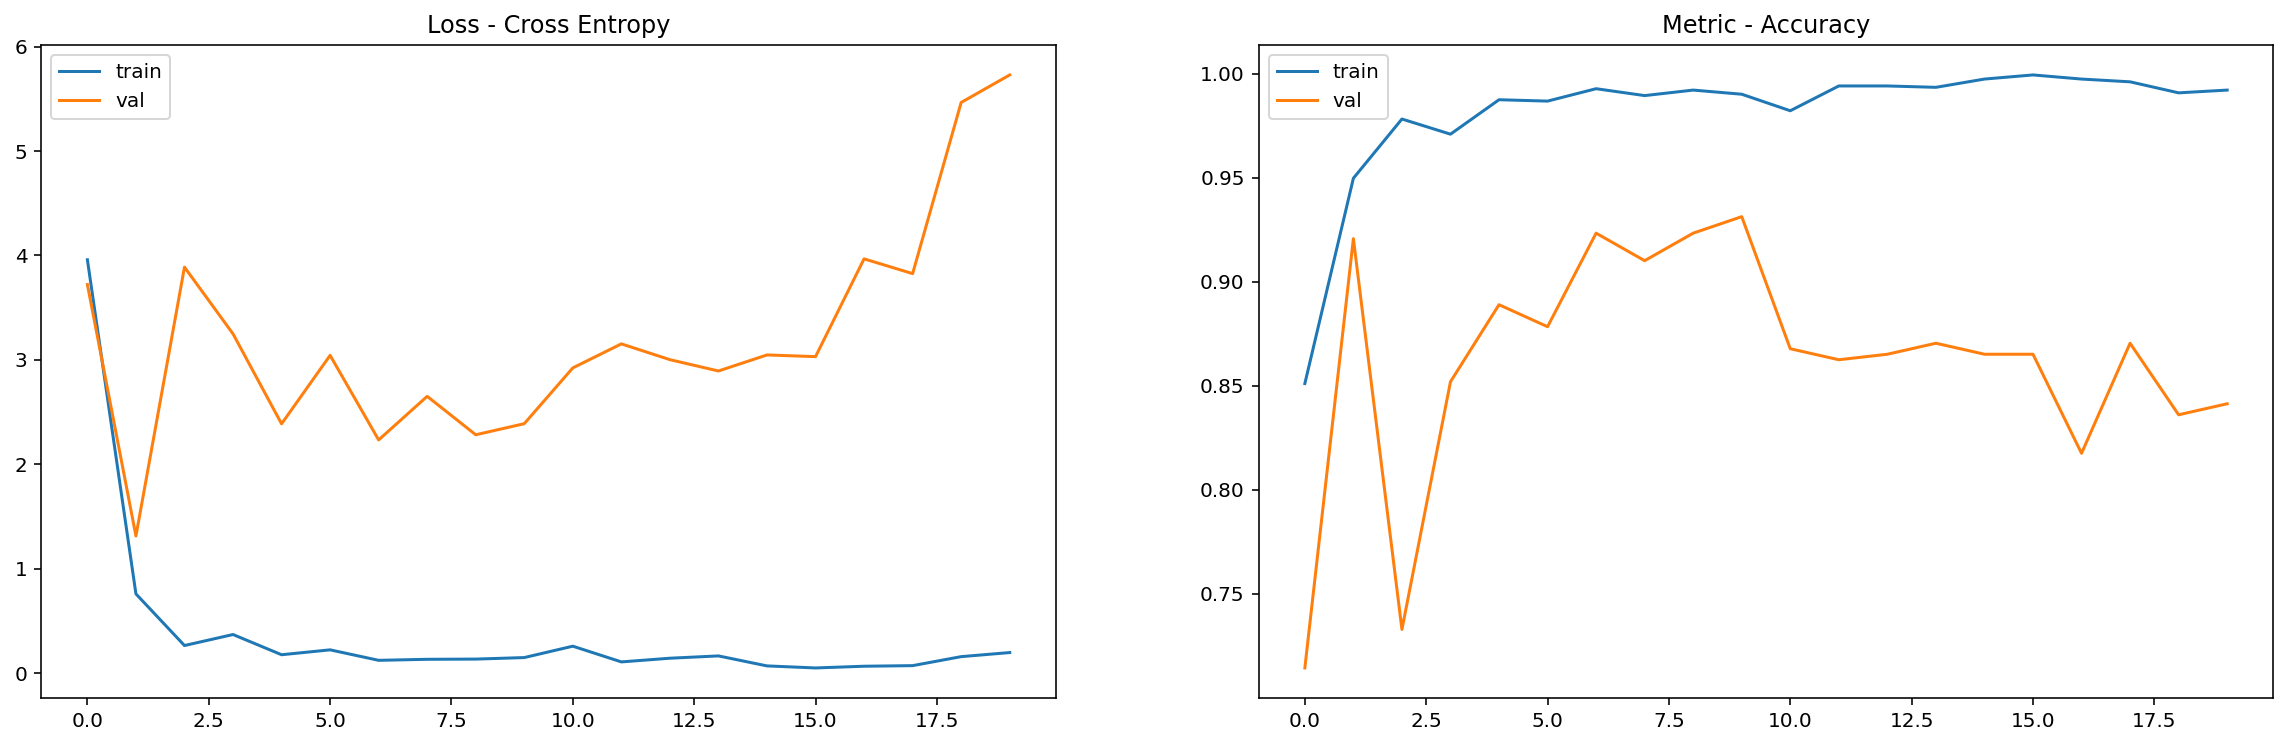

In [15]:
# Check results
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='val')
ax1.set_title('Loss - Cross Entropy')
ax1.legend()
ax2.plot(history.history['accuracy'], label='train')
ax2.plot(history.history['val_accuracy'], label='val')
ax2.set_title('Metric - Accuracy')
ax2.legend()
plt.show()

In [16]:
# Full Model training el modelo completo
for layer in model.layers:
    layer.trainable=True

In [17]:
# Retrain full model only 20 epochs
history = model.fit(x= stamps_df, y=y_categorical,
          epochs=20, 
          verbose=1, 
          validation_split=0.2,
          callbacks=[checkpointer, earlystop])

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.9974 - auc: 0.9973
Epoch 00001: val_accuracy did not improve from 0.93122
48/48 [==============================] - 22s 450ms/step - loss: 0.0673 - accuracy: 0.9974 - auc: 0.9973 - val_loss: 2.9697 - val_accuracy: 0.8677 - val_auc: 0.8813
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.0464 - accuracy: 0.9987 - auc: 1.0000
Epoch 00002: val_accuracy improved from 0.93122 to 0.96561, saving model to checkpoint.pmi-cnn-Inception.hdf5
48/48 [==============================] - 25s 518ms/step - loss: 0.0464 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 1.3051 - val_accuracy: 0.9656 - val_auc: 0.9680
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.0606 - accuracy: 0.9967 - auc: 0.9980
Epoch 00003: val_accuracy did not improve from 0.96561
48/48 [==============================] - 20s 417ms/step - loss: 0.0606 - accuracy: 0.9967 - auc: 0.9980 - val_loss: 2.1133 - val

In [18]:
# Save model and weights without training initial layers
for layer in model.layers:
    layer.trainable=False

# take best weights from training
model_name = 'inception_noaug_softmax_2.h5'
model.load_weights(checkpoint_file)

In [19]:
model.save(models_path + model_name)
model.save_weights(models_path + 'weights_' + model_name)

# Test

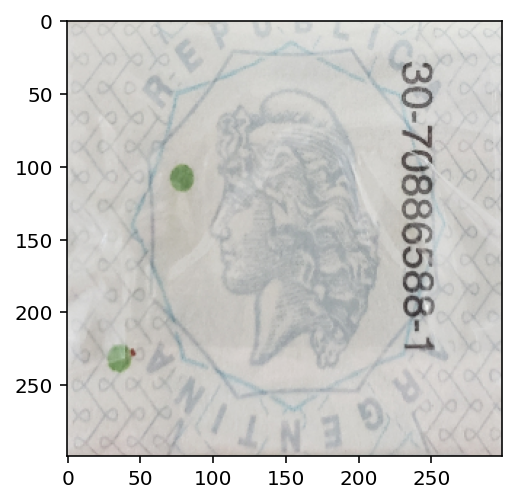

In [20]:
import cv2

imagen_1 = cv2.imread(test_path + 'cft_soft/20201016_113950.jpg' )
map = cv2.cvtColor(imagen_1, cv2.COLOR_BGR2RGB)
map = cv2.resize(map, dsize=(299,299))
plt.imshow(map)

In [21]:
map = map / 255
map = np.expand_dims(map, axis=0)
pred_1 = model.predict(map)
pred_1

# 0-1: fake
# 1-0: genuine

array([[2.493024e-04, 9.997507e-01]], dtype=float32)

In [ ]:
# CONFUSION MATRIX

In [22]:
cft_path = test_path + 'cft_box/'
false_positive = []
false_negative = []
X_train = []
y_train = []
for file in os.listdir(cft_path)[0:-1]:
  imagen_1 = cv2.imread(cft_path+file)
  map = cv2.cvtColor(imagen_1, cv2.COLOR_BGR2RGB)
  map = cv2.resize(map, dsize=(299,299))
  X_train.append(map)
  y_train.append(0)
  map = np.expand_dims(map/255, axis=0)
  ppp = model.predict(map)

gen_path = test_path + 'gen_box/'
for file in os.listdir(gen_path)[0:-1]:
  imagen_1 = cv2.imread(gen_path+file)
  map = cv2.cvtColor(imagen_1, cv2.COLOR_BGR2RGB)
  map = cv2.resize(map, dsize=(299,299))
  X_train.append(map)
  y_train.append(1)

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

In [24]:
X_train = np.array(X_train)/255

In [25]:
prediccion = model.predict(X_train)
result = []
for pred in prediccion:
  result.append(np.argmax(pred))
result = np.array(result)
print(result)

[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]


In [ ]:
confusion_matrix(y_train, result)

array([[0, 9],
       [9, 0]])

In [ ]:
cm = classification_report(y_train, result)
print(cm)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       9.0
           1       0.00      0.00      0.00       9.0

    accuracy                           0.00      18.0
   macro avg       0.00      0.00      0.00      18.0
weighted avg       0.00      0.00      0.00      18.0



# Save model to TFLITE

#### RESTART THE SESSION OR THIS FAILS

In [ ]:
import tensorflow as tf

models_path = 'drive/My Drive/Colab Notebooks/stamps/models/'
model_name = 'inception_noaug_softmax_2.h5'
model = tf.keras.models.load_model(models_path + model_name)
model.load_weights(models_path + 'weights_' + model_name)

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(models_path + 'inception_noaug_sm_2.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpigdoyr19/assets


In [ ]:
#### DONE v1 29/10/2020
#### Auth: Ariel Ferreiro / Victor Vivas